In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy.stats import norm

import warnings
warnings.filterwarnings('ignore')

In [3]:
df=pd.read_csv('00d-ROI_near_miss_results.txt',sep=',')

In [4]:
z_crit = norm.ppf(0.975)

In [5]:
def CI(cols):
    mean = cols[0]
    zscore = cols[1]
    return (mean - (z_crit*mean/zscore), mean + (z_crit*mean/zscore))



def get_CI(df):
    df['CI'] = df.apply(CI,axis=1)
    df['low'] = df['CI'].apply(lambda tup: tup[0])
    df['high'] = df['CI'].apply(lambda tup: tup[1])
    df.drop('CI',axis=1,inplace=True)
    return df

def plot(df,mean_colname,z_colname):
    effect_df = get_CI(df[[mean_colname,z_colname]])
    plt.figure(figsize=(10,6))
    plt.plot(effect_df.index,effect_df[mean_colname],marker='o')
    plt.fill_between(effect_df.index,effect_df['low'],effect_df['high'],
                     alpha=0.3)
    plt.axhline(y=0,linestyle = '--')
    _=plt.xticks(rotation=90,fontsize=12)
    _=plt.title(mean_colname,fontsize=18)

## Intercept (average activation acorss groups, TRs, conditions)

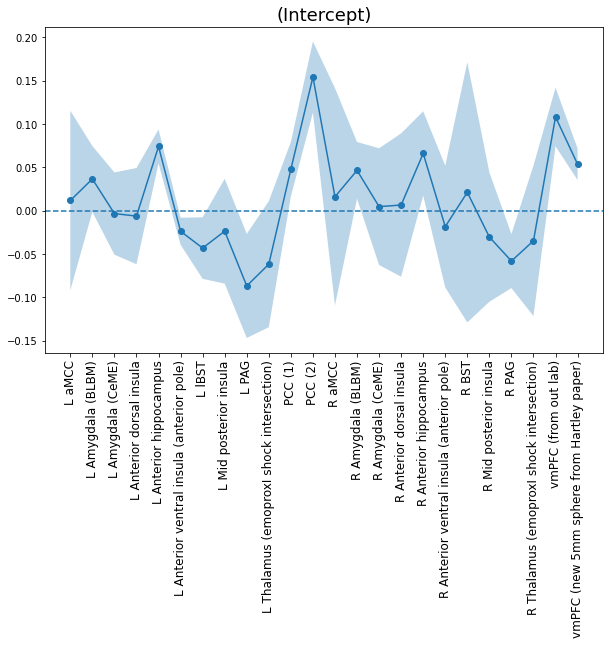

In [6]:
plot(df,'(Intercept)','(Intercept)-Z')

Observation:  
- Significant activation/deactivation in following ROIs:
    - Activation
        - Left & right anterior hippocampus 
        - PCC 1&2
        - Right amygdala (BLBM)
        - vmPFC (both)
    - Deactivation
        - Left anterior ventral insula (anterior pole)
        - Left BST
        - Left & Right PAG

## Group (control/uncontrol)

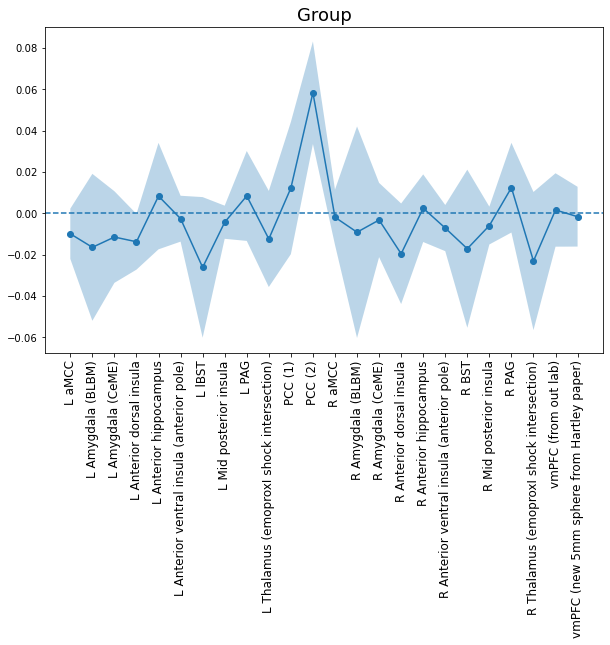

In [7]:
plot(df,'Group','Group-Z')

Observation:  
- Significant difference in activation (averaged across conditions and TR) between groups (control and uncontrol) in following ROI:
    - PCC (2)

## Condition (approach/retreat)

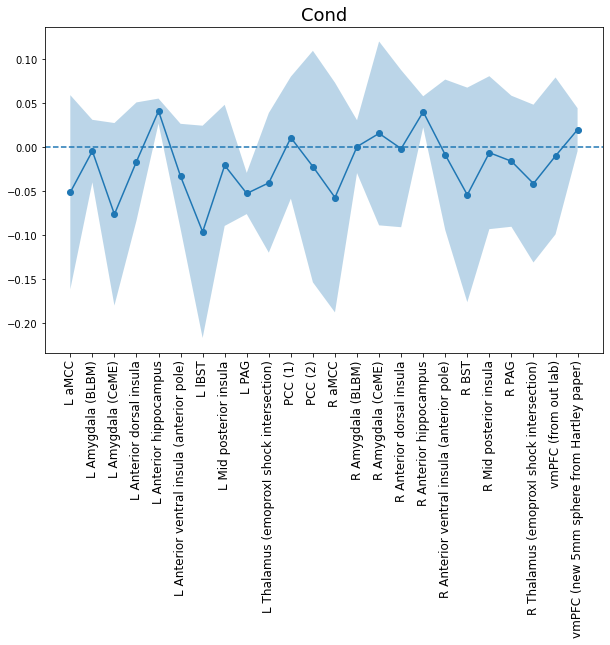

In [8]:
plot(df,'Cond','Cond-Z')

Observation:  
- Significant difference in activation (averaged across groups and TR) between approach and retreat in following ROI:
    - Left & right anterior hippocampus

## Condition-Group Interaction

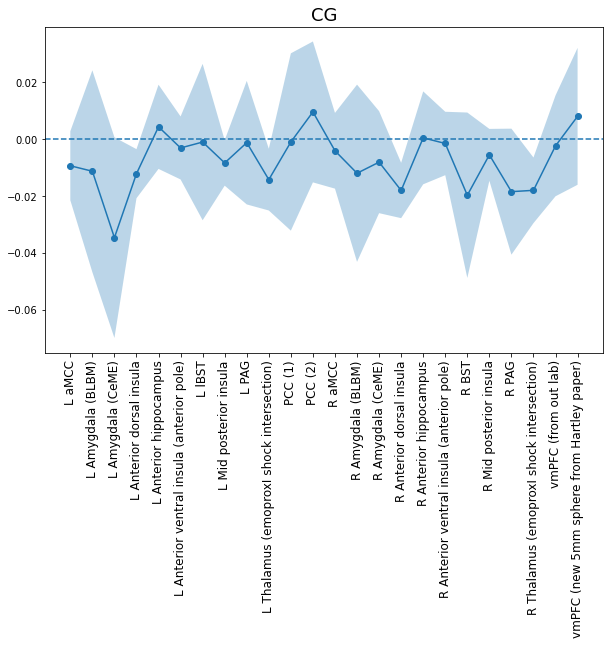

In [9]:
plot(df,'CG','CG-Z')

## Timepoint (TR)

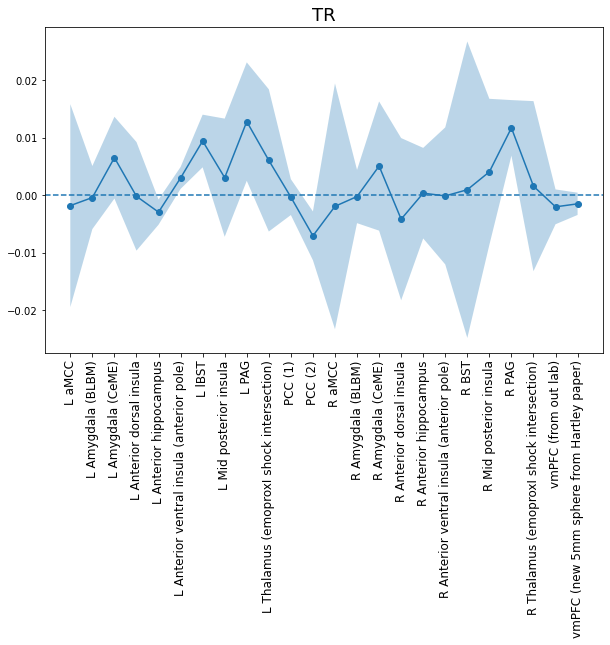

In [10]:
plot(df,'TR','TR-Z')

## Group-TR Interaction

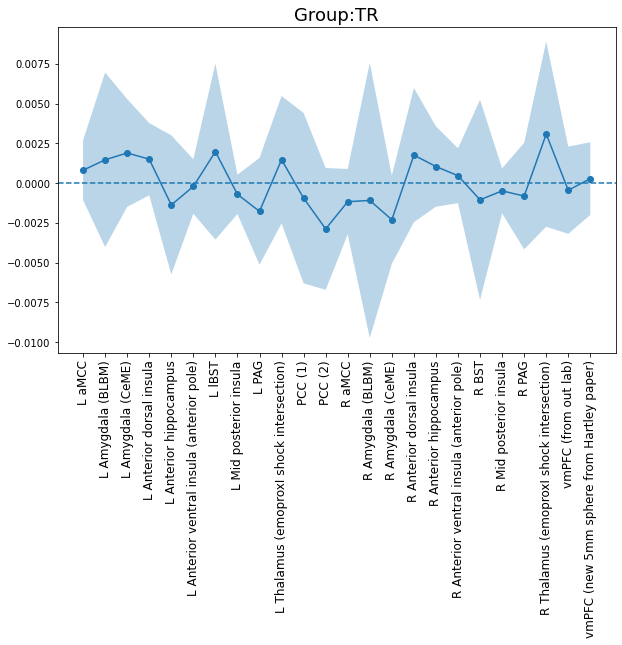

In [11]:
plot(df,'Group:TR','Group:TR-Z')

## Condition-TR Interaction

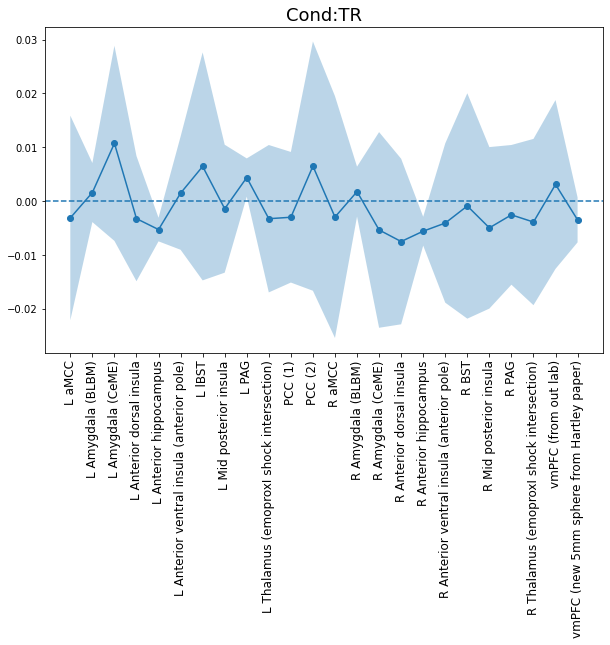

In [12]:
plot(df,'Cond:TR','Cond:TR-Z')

## Condition-Group-TR Intercation

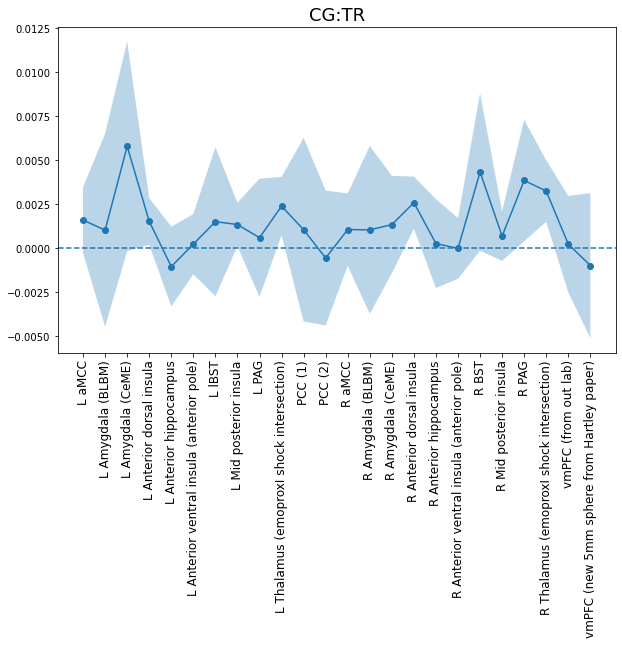

In [13]:
plot(df,'CG:TR','CG:TR-Z')

# Non-Linear Effects (Chi-square with 2 DFs)

In [14]:
nonlin_ef = df.iloc[:,16:20]
nonlin_ef = nonlin_ef.stack().to_frame().reset_index()
nonlin_ef.columns = ['ROI','effect','estimate']

s(TR):Group = TR-group interaction
s(TR):Cond = TR-condition interaction
s(TR):CG = TR-condition-group interaction


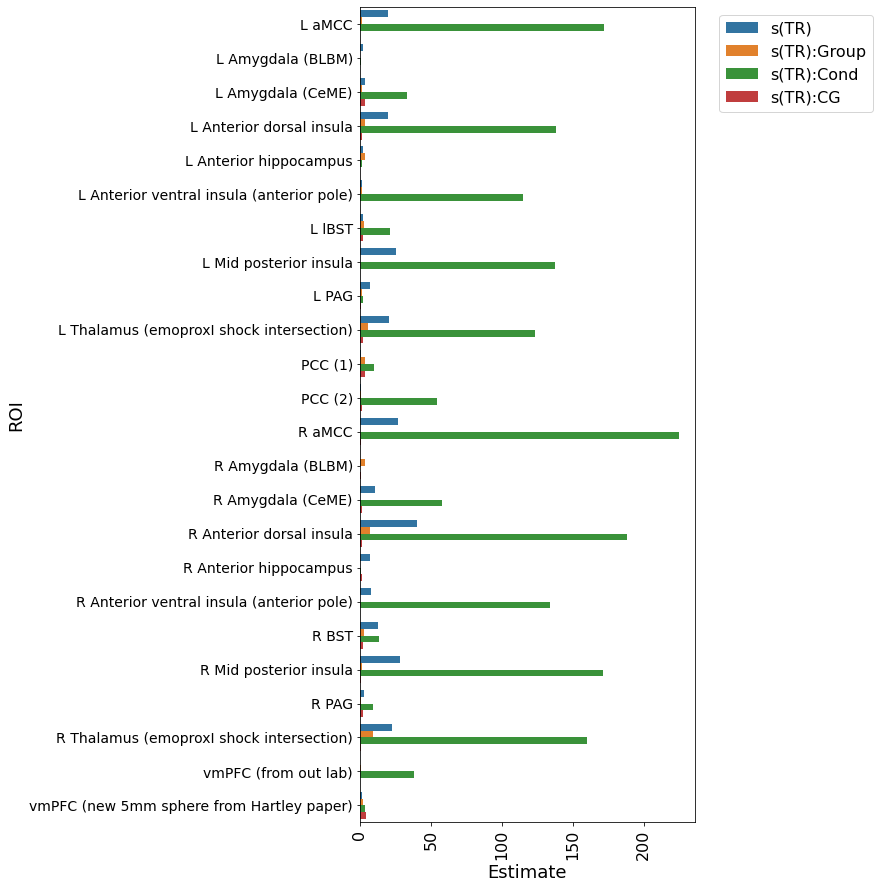

In [15]:
plt.figure(figsize = (6,15))
sns.barplot(y='ROI',x='estimate',hue='effect',data=nonlin_ef,orient='h')
_=plt.xticks(rotation = 90,fontsize=16)
_=plt.yticks(fontsize=14)
_=plt.legend(fontsize=16,bbox_to_anchor=(1.05,1))
_=plt.xlabel('Estimate',fontsize=18)
_=plt.ylabel('ROI',fontsize=18)
print('s(TR):Group = TR-group interaction')
print('s(TR):Cond = TR-condition interaction')
print('s(TR):CG = TR-condition-group interaction')

# Estimates

In [16]:
resp = df.iloc[:,22:86][[col for col in df.iloc[:,22:86] if 'se' not in col]]
resp = resp.stack().to_frame().reset_index()
resp.columns = ['ROI','temp','response']
resp['group'] = resp['temp'].apply(lambda temp: 'control' if temp[0] == 'C' else 'uncontrol')
resp['condition'] = resp['temp'].apply(lambda temp: 'approach' if temp[1] == 'A' else 'retreat')
resp['TR'] = resp['temp'].apply(lambda temp: float(temp[3:]))
resp.drop('temp',axis=1,inplace=True)


se = df.iloc[:,22:86][[col for col in df.iloc[:,22:86] if 'se' in col]]
se = se.stack().to_frame().reset_index()
se.columns = ['ROI','temp','se']
se['group'] = se['temp'].apply(lambda temp: 'control' if temp[0] == 'C' else 'uncontrol')
se['condition'] = se['temp'].apply(lambda temp: 'approach' if temp[1] == 'A' else 'retreat')
se['TR'] = se['temp'].apply(lambda temp: float(temp[3:-2]))
se.drop('temp',axis=1,inplace=True)

resp = resp.merge(se)

In [17]:
from scipy.stats import t as tdist
critT = tdist(df=60).ppf(0.975)

In [18]:
rois = resp.ROI.unique()
t = resp.TR.unique()

## Control: Approach vs. Retreat

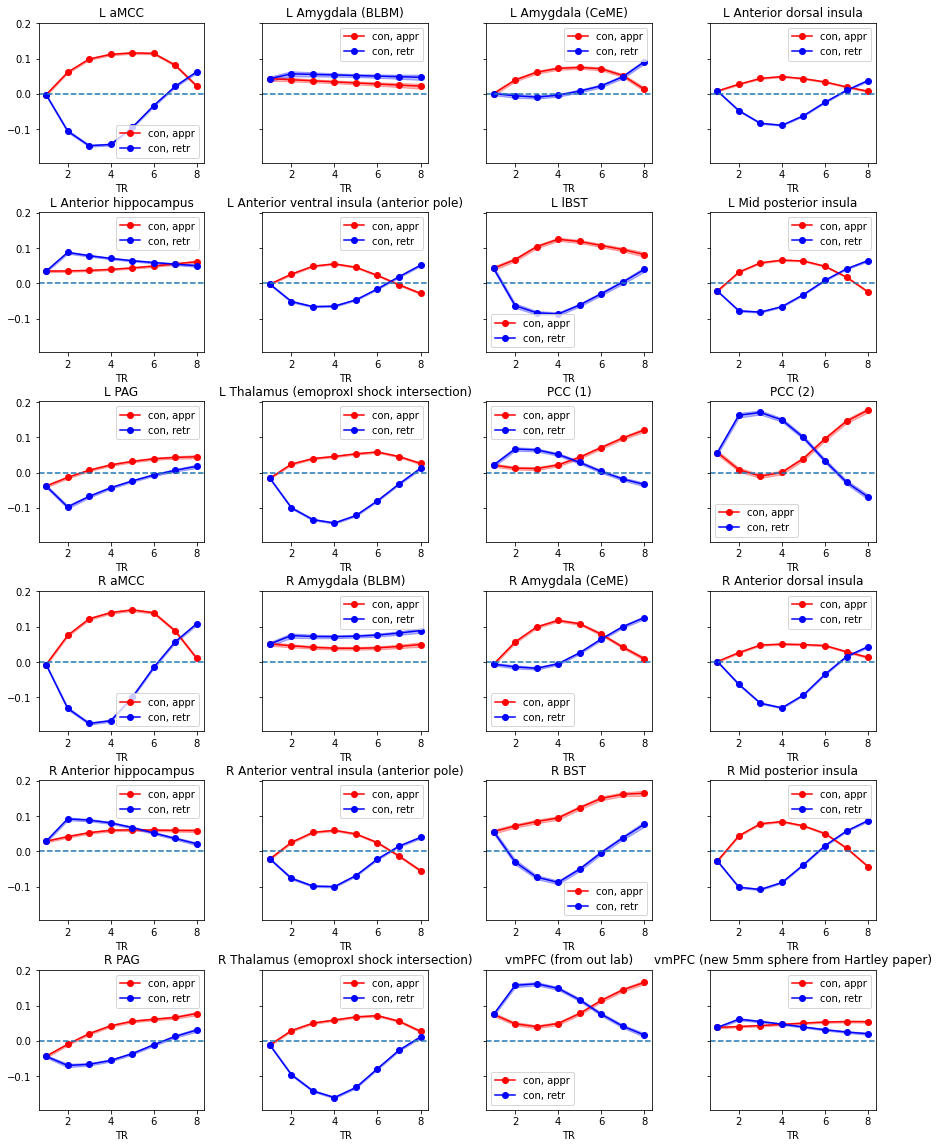

In [19]:
fig, axes = plt.subplots(nrows=6,ncols=4,figsize=(15,20),sharey=True)
axes = axes.flatten()

fig.subplots_adjust(wspace=0.35,hspace=0.35)

for i, roi in enumerate(rois):
    appr = resp[(resp['ROI']==roi) & (resp['group']=='control') & (resp['condition']=='approach')]
    retr = resp[(resp['ROI']==roi) & (resp['group']=='control') & (resp['condition']=='retreat')]
    
    axes[i].plot(t,appr['response'],label='con, appr',color='red',marker='o')
    axes[i].fill_between(t,
                         appr['response'] - (critT*(appr['se']/np.sqrt(61))),
                         appr['response'] + (critT*(appr['se']/np.sqrt(61))),
                         alpha=0.3,color='red')
    
    axes[i].plot(t,retr['response'],label='con, retr',color='blue',marker='o')
    axes[i].fill_between(t,
                         retr['response'] - (critT*(retr['se']/np.sqrt(61))),
                         retr['response'] + (critT*(retr['se']/np.sqrt(61))),
                         alpha=0.3,color='blue')
    
    axes[i].axhline(y=0,linestyle = '--')
    axes[i].set_title(roi)
    axes[i].set_xlabel('TR')
    
    axes[i].legend()
#fig.legend(axes[i].get_legend_handles_labels()[1],
#           loc='upper right',
#           bbox_to_anchor=(0.95,0.8),
#           fontsize=16)

## Uncontrol: Approach vs. Retreat

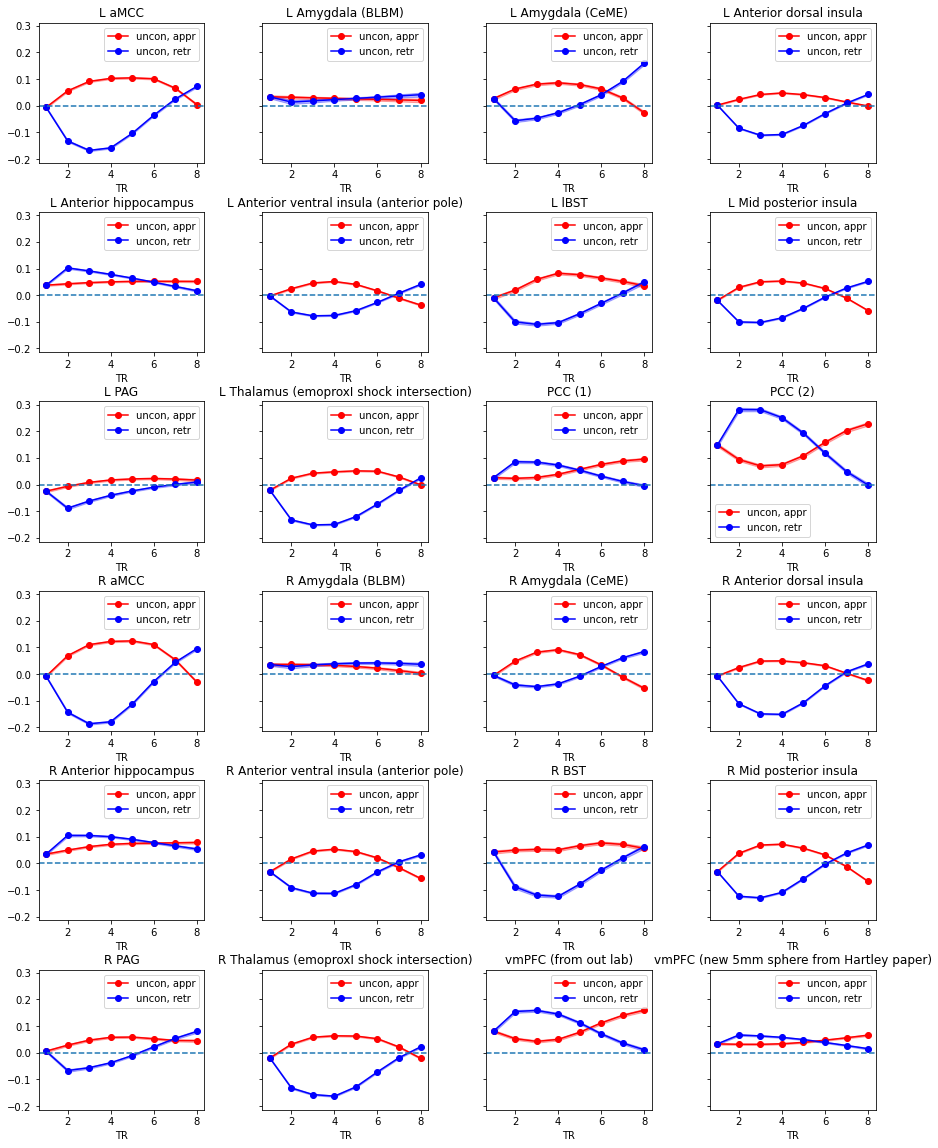

In [20]:
fig, axes = plt.subplots(nrows=6,ncols=4,figsize=(15,20),sharey=True)
axes = axes.flatten()

fig.subplots_adjust(wspace=0.35,hspace=0.35)

for i, roi in enumerate(rois):
    appr = resp[(resp['ROI']==roi) & (resp['group']=='uncontrol') & (resp['condition']=='approach')]
    retr = resp[(resp['ROI']==roi) & (resp['group']=='uncontrol') & (resp['condition']=='retreat')]
    
    axes[i].plot(t,appr['response'],label='uncon, appr',color='red',marker='o')
    axes[i].fill_between(t,
                         appr['response'] - (critT*(appr['se']/np.sqrt(61))),
                         appr['response'] + (critT*(appr['se']/np.sqrt(61))),
                         alpha=0.3,color='red')
    
    axes[i].plot(t,retr['response'],label='uncon, retr',color='blue',marker='o')
    axes[i].fill_between(t,
                         retr['response'] - (critT*(retr['se']/np.sqrt(61))),
                         retr['response'] + (critT*(retr['se']/np.sqrt(61))),
                         alpha=0.3,color='blue')
    
    axes[i].axhline(y=0,linestyle = '--')
    axes[i].set_title(roi)
    axes[i].set_xlabel('TR')
    
    axes[i].legend()
#fig.legend(axes[i].get_legend_handles_labels()[1],
#           loc='upper right',
#           bbox_to_anchor=(0.95,0.8),
#           fontsize=16)

## Approach: Uncontrol vs. Control

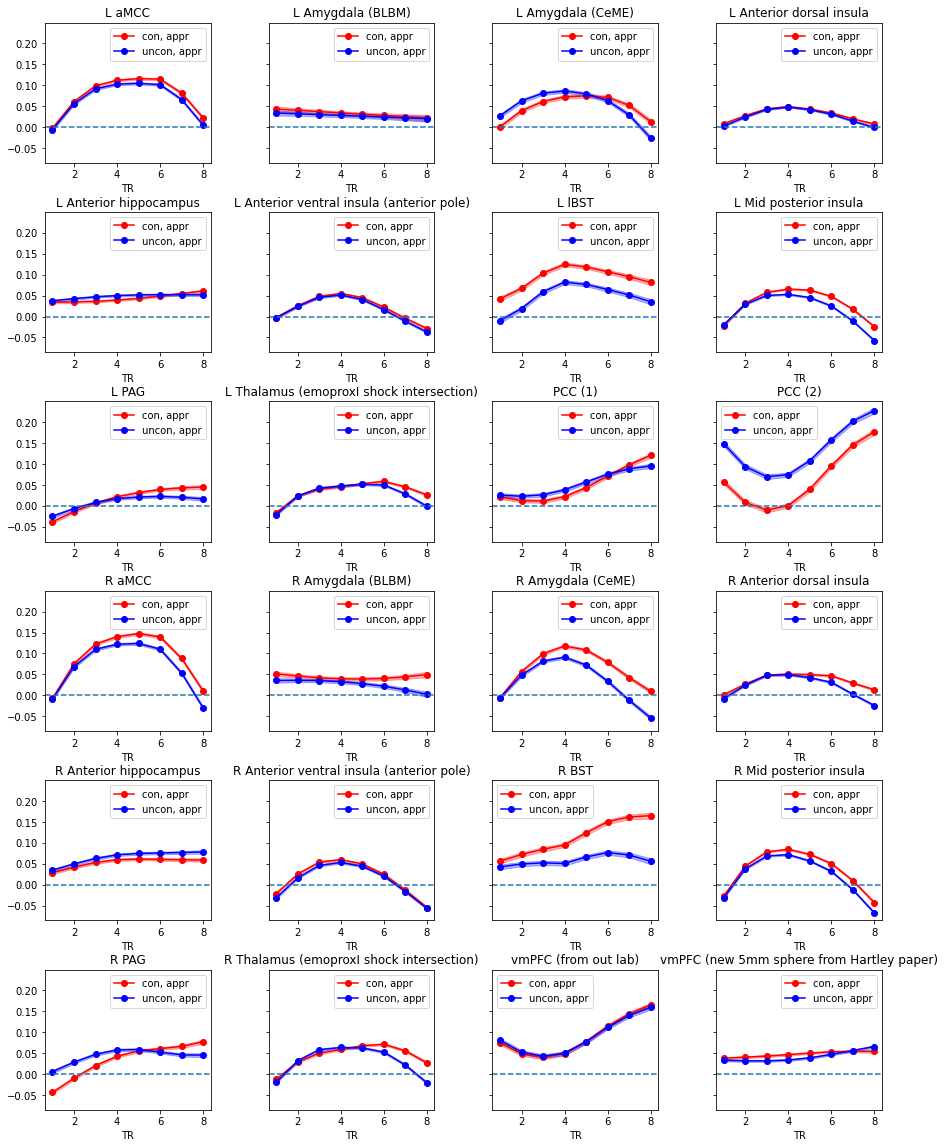

In [21]:
fig, axes = plt.subplots(nrows=6,ncols=4,figsize=(15,20),sharey=True)
axes = axes.flatten()

fig.subplots_adjust(wspace=0.35,hspace=0.35)

for i, roi in enumerate(rois):
    con = resp[(resp['ROI']==roi) & (resp['group']=='control') & (resp['condition']=='approach')]
    uncon = resp[(resp['ROI']==roi) & (resp['group']=='uncontrol') & (resp['condition']=='approach')]
    
    axes[i].plot(t,con['response'],label='con, appr',color='red',marker='o')
    axes[i].fill_between(t,
                         con['response'] - (critT*(con['se']/np.sqrt(61))),
                         con['response'] + (critT*(con['se']/np.sqrt(61))),
                         alpha=0.3,color='red')
    
    axes[i].plot(t,uncon['response'],label='uncon, appr',color='blue',marker='o')
    axes[i].fill_between(t,
                         uncon['response'] - (critT*(uncon['se']/np.sqrt(61))),
                         uncon['response'] + (critT*(uncon['se']/np.sqrt(61))),
                         alpha=0.3,color='blue')
    
    axes[i].axhline(y=0,linestyle = '--')
    axes[i].set_title(roi)
    axes[i].set_xlabel('TR')
    
    axes[i].legend()
#fig.legend(axes[i].get_legend_handles_labels()[1],
#           loc='upper right',
#           bbox_to_anchor=(0.95,0.8),
#           fontsize=16)

## Retreat: Uncontrol vs. Control

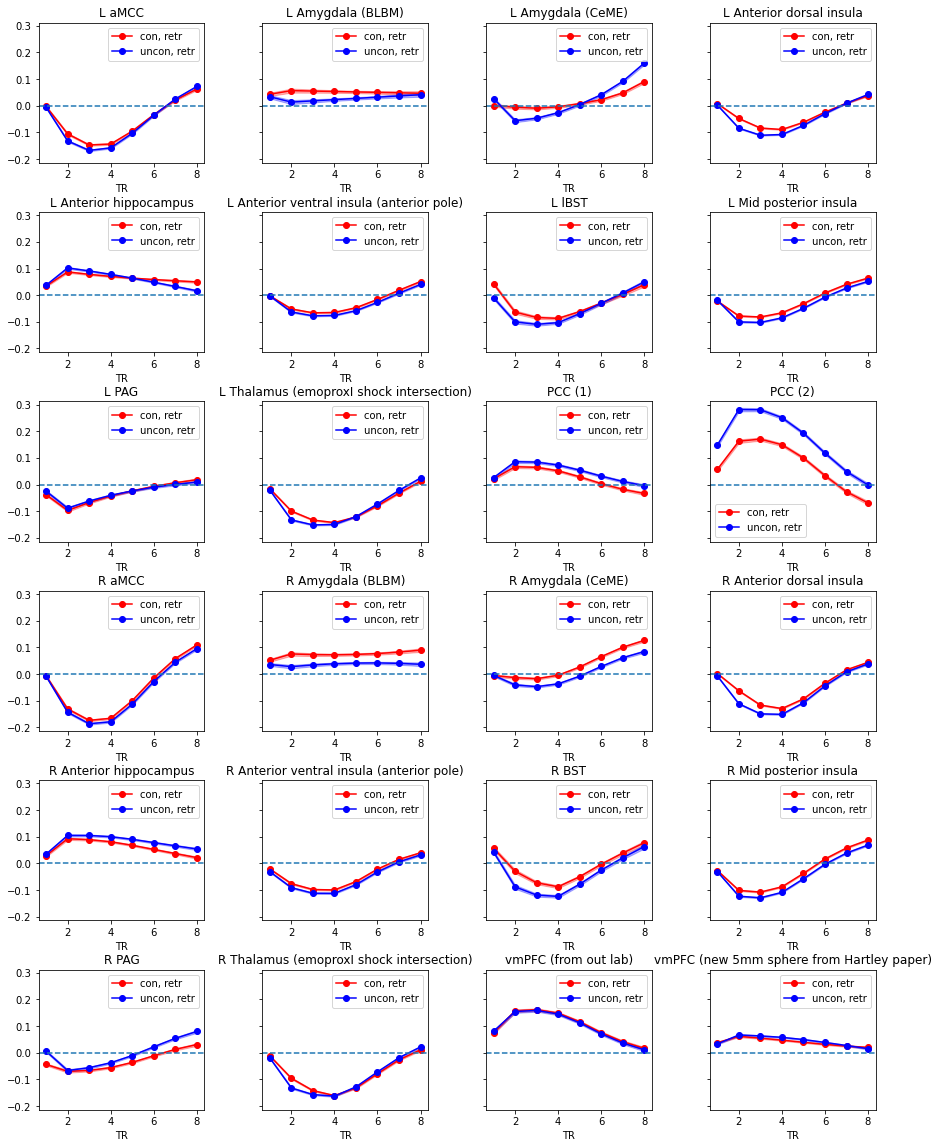

In [22]:
fig, axes = plt.subplots(nrows=6,ncols=4,figsize=(15,20),sharey=True)
axes = axes.flatten()

fig.subplots_adjust(wspace=0.35,hspace=0.35)

for i, roi in enumerate(rois):
    con = resp[(resp['ROI']==roi) & (resp['group']=='control') & (resp['condition']=='retreat')]
    uncon = resp[(resp['ROI']==roi) & (resp['group']=='uncontrol') & (resp['condition']=='retreat')]
    
    axes[i].plot(t,con['response'],label='con, retr',color='red',marker='o')
    axes[i].fill_between(t,
                         con['response'] - (critT*(con['se']/np.sqrt(61))),
                         con['response'] + (critT*(con['se']/np.sqrt(61))),
                         alpha=0.3,color='red')
    
    axes[i].plot(t,uncon['response'],label='uncon, retr',color='blue',marker='o')
    axes[i].fill_between(t,
                         uncon['response'] - (critT*(uncon['se']/np.sqrt(61))),
                         uncon['response'] + (critT*(uncon['se']/np.sqrt(61))),
                         alpha=0.3,color='blue')
    
    axes[i].axhline(y=0,linestyle = '--')
    axes[i].set_title(roi)
    axes[i].set_xlabel('TR')
    
    axes[i].legend()
#fig.legend(axes[i].get_legend_handles_labels()[1],
#           loc='upper right',
#           bbox_to_anchor=(0.95,0.8),
#           fontsize=16)